<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../resources/change_detection_schematic.png" height="400" width="400">  


In [3]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# Import allensdk modules for loading and interacting with the data
from allensdk.internal.api import behavior_ophys_api as boa #TODO: We probably won't use this, but instead use the NWB api
from allensdk.brain_observatory.behavior import behavior_ophys_session as bos

from importlib import reload
reload(boa)
reload(bos)

<module 'allensdk.brain_observatory.behavior.behavior_ophys_session' from '/home/alex.piet/allen_sdk/sdk/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_session.py'>

In [5]:
from allensdk.brain_observatory.behavior.swdb import behavior_project_cache as bpc

cache_json = {'manifest_path': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/visual_behavior_data_manifest.csv',
              'nwb_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/nwb_files',
              'analysis_files_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/extra_files'
              }
cache = bpc.BehaviorProjectCache(cache_json)
manifest = cache.manifest

In [25]:
experiment_id = 792812544
session = cache.get_session(experiment_id)

In [9]:
tr = session.trial_response_df


In [12]:
fr = session.flash_response_df

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot basic behavioral metrics over the session**

<p> 1) Plot the hit rate in a sliding window using the trial_response_dataframe.

<p> 2) Plot the false alarm rate in a sliding window

<p> 3) Plot the d` metric in a sliding window. 
    
<p> 4) What do you notice about this session?  How does the behavior influence how we should analyze the neural activity?

</div>

In [13]:
#define a sliding window to calculate teh hit rate, fa rate, and d-prime over
sliding_window=10

#first we extract the trials from the dataframe. Then we exclude aborted trials
trials=session.trials[session.trials.aborted==False]

Text(0, 0.5, 'Hit Alarm Rate')

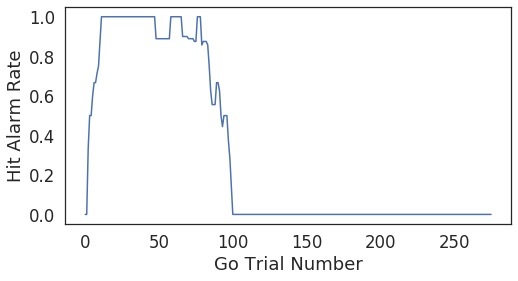

In [14]:
# SOLUTION
#Re-index
trials=trials.reset_index(drop=True)

#create empty arrays(pandas series) for go_responses and catch_responses to fill later
go_responses = pd.Series([np.nan] * len(trials))      

#encode true hits as one
go_responses[trials.loc[(trials['go']==True) &(trials['hit']==True)].index]=1
#encode misses on go trials as zero
go_responses[trials.loc[(trials['go']==True) &(trials['hit']==False)].index]=0

#note that after this, trials that are not GO are encoded as NaN in the go responses mask. We've excluded aborted
hit_rate = go_responses.rolling(window=sliding_window,min_periods=0).mean()

fig, ax = plt.subplots(figsize=(8,4))

ax.plot (hit_rate)

ax.set_xlabel ('Go Trial Number')
ax.set_ylabel ('Hit Alarm Rate')

Text(0, 0.5, 'False Alarm Rate')

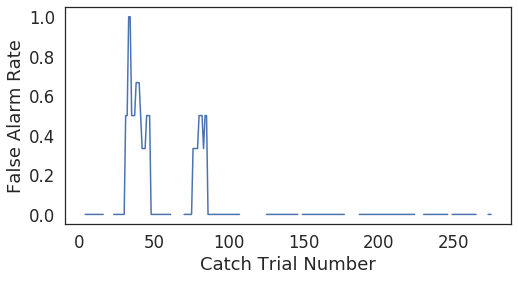

In [22]:
# SOLUTION
catch_responses = pd.Series([np.nan] * len(trials))
#false alarms are defined as responses on catch trials
catch_responses[trials.loc[(trials['catch']==True) & (trials['false_alarm']==True)].index]=1
catch_responses[trials.loc[(trials['catch']==True) & (trials['false_alarm']==False)].index]=0

fa_rate = catch_responses.rolling(window=sliding_window,min_periods=0).mean()


fig, ax = plt.subplots(figsize=(8,4))

ax.plot(fa_rate)

ax.set_xlabel ('Catch Trial Number')
ax.set_ylabel ('False Alarm Rate')

In [16]:
def dprime(hit_rate, fa_rate, limits=(0.01, 0.99)):
    
    from scipy.stats import norm
    """ calculates the d-prime for a given hit rate and false alarm rate
    https://en.wikipedia.org/wiki/Sensitivity_index
    Parameters
    ----------
    hit_rate : float
        rate of hits in the True class
    fa_rate : float
        rate of false alarms in the False class
    limits : tuple, optional
        limits on extreme values, which distort. default: (0.01,0.99)
    Returns
    -------
    d_prime
    """
    assert limits[0] > 0.0, 'limits[0] must be greater than 0.0'
    assert limits[1] < 1.0, 'limits[1] must be less than 1.0'
    #use Percent point function.
    #specifies the value of the variable such that the probability of the variable being less than or equal
    #to that value equals the given probability
    Z = norm.ppf

    # Limit values in order to avoid d' infinity
    hit_rate = np.clip(hit_rate, limits[0], limits[1])
    fa_rate = np.clip(fa_rate, limits[0], limits[1])

    return Z(hit_rate) - Z(fa_rate)

/home/alex.piet/codebase/miniconda3/envs/visbeh/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1977: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/home/alex.piet/codebase/miniconda3/envs/visbeh/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1977: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


Text(0, 0.5, 'D-Prime')

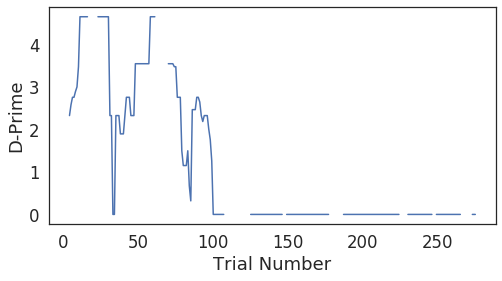

In [17]:
# SOLUTION
d_prime=dprime(hit_rate, fa_rate)

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(d_prime)

ax.set_xlabel ('Trial Number')
ax.set_ylabel ('D-Prime')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot the reaction time for hit trials**

<p> Plot the reaction time over the session. The reaction time is how long it takes for the mouse to lick on hit trials. 

</div>

Text(0, 0.5, 'Reaction Time (ms)')

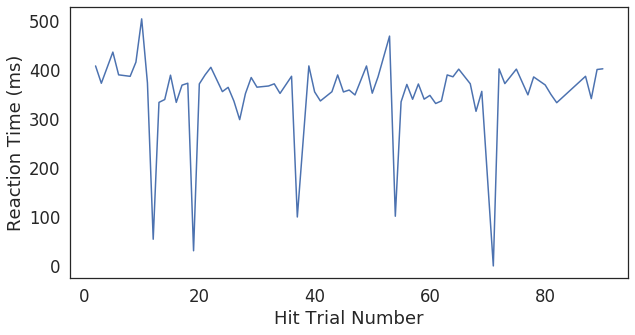

In [23]:
# SOLUTION
first_licks=[lick[0] for lick in trials.loc[(trials['go']==True) &(trials['hit']==True)]['lick_times']]

change_times=trials.loc[(trials['go']==True) &(trials['hit']==True)].change_time

reaction_time=first_licks-change_times
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reaction_time*1000)

ax.set_xlabel ('Hit Trial Number')
ax.set_ylabel ('Reaction Time (ms)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot the hit rate transition matrix**

The task cycles through 8 different images. Some transitions (A-B) might be easier for the mouse to detect. Plot the hit transition matrix as a heatmap. On each axis should be the image name. 

</div>

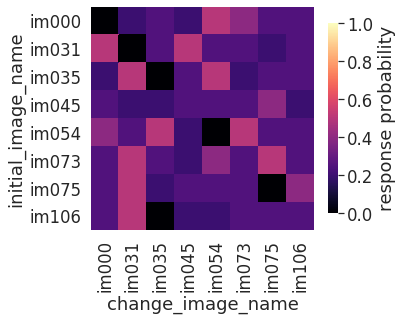

In [24]:
# SOLUTION
trials['response_latency_binary'] = [1 if response_latency<0.75 else 0 for response_latency in trials.response_latency.values]
trials['response_binary'] = [1 if np.isnan(response_time)==False else 0 for response_time in trials.response_time.values]
response_matrix = pd.pivot_table(trials,  
                                 values='response_latency_binary', 
                                 index=['initial_image_name'],
                                 columns=['change_image_name'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(response_matrix, cmap='magma', square=True, annot=False,
            annot_kws={"fontsize": 10}, vmin=0, vmax=1,
            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Find maximally responsive cells**

<p> 1) Which trial evoked the largest response? Which cell had the largest response during the trial? Plot the df/f for that cell on that trial. Plot the change time. What type of trial was it, a go or catch trial?

<p> 2) Plot the average df/f for that cell for all trials of that image
    
<p> 3) Plot the average df/f for that cell for each different image
    

</div>

Cell id: 792865159
Trial id: 287
Go trial: True
Catch trial: False
Change image: im054


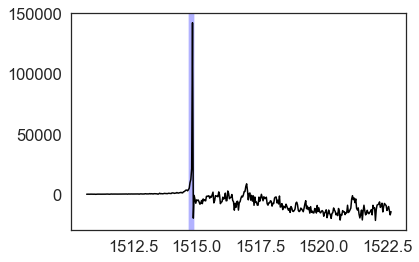

In [142]:
# Solution
max_cell_trial = tr.loc[tr.mean_response.idxmax()]
cell_id,trial_id = tr.mean_response.idxmax()
print('Cell id: ' + str(cell_id))
print('Trial id: ' + str(trial_id))
print('Go trial: ' + str(max_cell_trial.go))
print('Catch trial: ' + str(max_cell_trial.catch))
print('Change image: ' + str(max_cell_trial.change_image_name))
change_image = max_cell_trial.change_image_name
plt.plot(max_cell_trial.dff_trace_timestamps, max_cell_trial.dff_trace,'k-')
plt.axvspan(max_cell_trial.change_time, max_cell_trial.change_time + 0.25 ,alpha=0.3,facecolor='blue')

In [56]:
# SOLUTION
# Compute Average df/f, annoying because everything is a list
def get_average_dff_by_image(cell_id, image_name):
    all_dffs =tr[['dff_trace']][(tr.cell_roi_id == cell_id) & (tr.change_image_name == image_name)].values
    average_dff = np.zeros(np.shape(all_dffs[0,0]))
    for x in all_dffs:
        average_dff += np.array(x[0])
    average_dff = average_dff/len(all_dffs)
    timestamps = tr.iloc[0].dff_trace_timestamps  - tr.iloc[0].change_time
    return timestamps, average_dff

Text(0.5, 0, 'Time from change (s)')

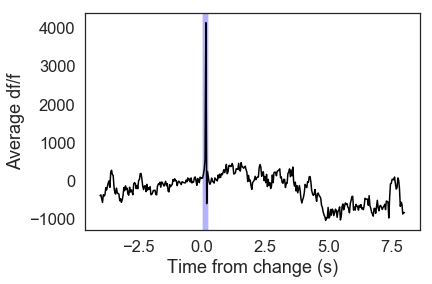

In [57]:
# SOLUTION
# Plot average df/f
timestamps, average_dff = get_average_dff_by_image(cell_id,change_image)
plt.plot(timestamps,average_dff,'k')
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('Average df/f')
plt.xlabel('Time from change (s)')

Text(0.5, 0, 'Time from change (s)')

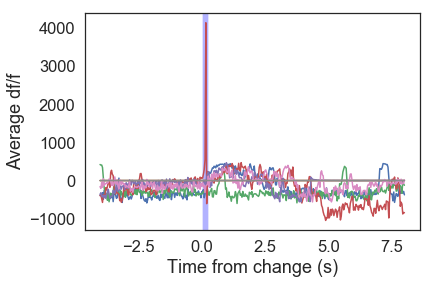

In [58]:
unique_images = tr.change_image_name.unique()
for image in unique_images:
    timestamps, average_dff = get_average_dff_by_image(cell_id, image)
    plt.plot(timestamps, average_dff)
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('Average df/f')
plt.xlabel('Time from change (s)')


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Compute trial averaged response for all cells **

<p> 1) Compute a `heat map` image that shows each cell's average response across all trials

<p> 2) What structure do you see in this population? Sorting the cells can help see structure.

</div>

In [220]:
def get_average_dff(cell_id):
    all_dffs =tr[['dff_trace']][(tr.cell_roi_id == cell_id)].values
    average_dff = np.zeros(np.shape(all_dffs[0,0]))
    for x in all_dffs:
        average_dff += np.array(x[0])
    average_dff = average_dff/len(all_dffs)
    timestamps = tr.iloc[0].dff_trace_timestamps  - tr.iloc[0].change_time
    return timestamps, average_dff

In [199]:
timestamps, dff = get_average_dff(cell_id)
cells = tr.cell_roi_id.unique()
heatmap = np.zeros((len(cells), len(dff)))
count = 0
for cell in cells:
    timestamps, dff = get_average_dff(cell)
    heatmap[count,:] = dff
    count+=1
    
heatmap= heatmap[~np.any(np.isnan(heatmap),axis=1),:]
heatmap= heatmap[~np.any(heatmap > 5,axis=1),:]
heatmap= heatmap[~np.any(heatmap < -5,axis=1),:]

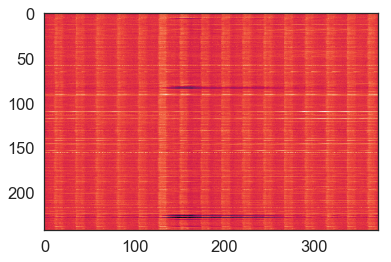

In [200]:
plt.imshow(heatmap)

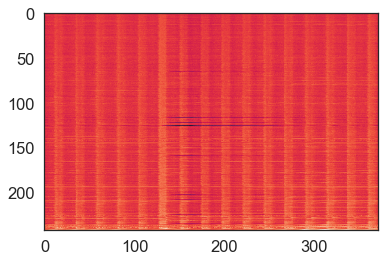

In [201]:
x = np.argsort(np.max(heatmap,1))
heatmap_sorted = heatmap[x,:]
plt.imshow(heatmap_sorted)

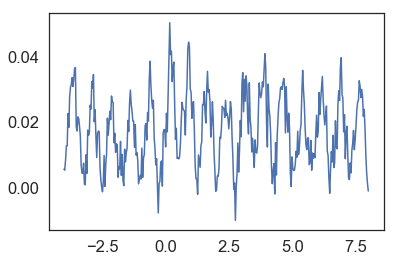

In [202]:
plt.plot(timestamps, heatmap_sorted[100,:])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Plot the cell's' trial averaged response for go and catch trials**

<p>1) For your cell, plot the average trial response for all images on go trials

<p>2) Repeat for 'catch' trials. How is the response different than on 'go' trials? 
</div>

In [223]:
df_go = tr[tr.go]
df_catch = tr[tr.catch]

def get_average_dff_type(df,cell_id):
    all_dffs =df[['dff_trace']][(df.cell_roi_id == cell_id)].values
    average_dff = np.zeros(np.shape(all_dffs[0,0]))
    for x in all_dffs:
        average_dff += np.array(x[0])
    average_dff = average_dff/len(all_dffs)
    timestamps = df.iloc[0].dff_trace_timestamps  - df.iloc[0].change_time
    return timestamps, average_dff

timestamps, average_go = get_average_dff_type(df_go,cell_id)
timestamps, average_catch = get_average_dff_type(df_catch,cell_id)



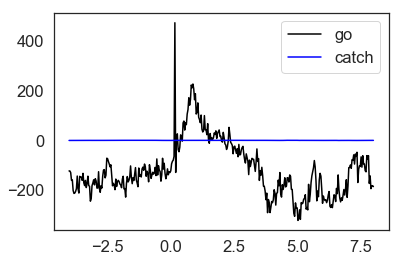

In [229]:
plt.plot(timestamps, average_go, 'k',label='go')
plt.plot(timestamps, average_catch, 'b',label='catch')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Plot an image tuning curve for responses to the first flash after a change on 'go' trials**

<p>1) Filter `trial_response_df` to select only 'go' trials and assign to a variable called `df`. The `mean_response` column of the `trial_response_df` is the mean of the dF/F trace in a 500ms window after the change time for that trial.



<p>2) Loop through each `change_image_name` in `df.change_image_name.unique()` and get the values of the `mean_response` column for your `cell`.



<p>3) Take the average and SEM of the `mean_response` values for each `change_image_name` and plot a tuning curve. Hint: use `from scipy.stats import sem` to get a function to compute the standard error. 



<p>4) Save the averaged response to each image as an array called 'image_responses'.
</div>

In [209]:
df_go = tr[tr.go]
df_catch = tr[tr.catch]

In [210]:
from scipy.stats import sem
def compute_average_image_responses(df, cellid):
    image_responses = []
    standard_errors = []
    for image in df.change_image_name.unique():
        mean_response = df[(df.cell_roi_id == cellid) & (df.change_image_name == image)].mean_response.values
        image_responses.append(np.mean(mean_response[~np.isnan(mean_response)]))
        standard_errors.append(sem(mean_response[~np.isnan(mean_response)]))
    image_responses = np.array(image_responses)
    return image_responses
image_responses = compute_average_image_responses(df_go,cell_id)


Text(0, 0.5, 'Average df/f')

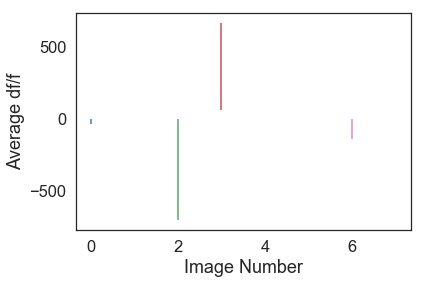

In [211]:
for i in range(0,8):
    plt.errorbar(i,image_responses[i], yerr=standard_errors[i])
plt.xlabel('Image Number')
plt.ylabel('Average df/f')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Computing lifetime sparseness </h2>
<p>'lifetime sparseness' is a metric for how selective and sparse a cell's activity is across conditions, bounded between 0 and 1. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p>We will compute this metric for single cells and take the mean across the population. Before taking the mean, we will filter out cells that do not have a signficant image response.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Compute lifetime sparseness using the mean image response on 'go' trials for your cell**
<p>1) Provide the array of `image_responses` created in Exercise 5.9 to the function below to compute the lifetime sparseness metric for your cell. How selective is this cell? 
    
<p>2) Using the average trial response you generated before for all cells, compute the spareness over flashes in each trial. Do some cells respond evenly across the trial, or do other modulate their responses?
</div>

In [212]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [213]:
ls = compute_lifetime_sparseness(np.abs(image_responses))
print(ls)

0.7905468159654477


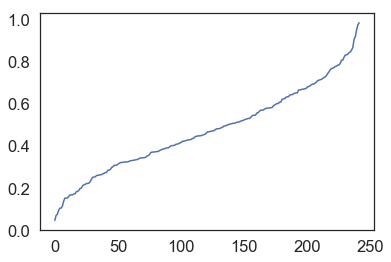

In [214]:
ls = compute_lifetime_sparseness(heatmap.T)
plt.plot(np.sort(ls))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Identify cells with a significant image response**
<p>The `p_value` column of the `trial_response_df` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the change time with the 500ms after the change time. This window is specified in the `response_window_duration` attribute of the `analysis` object. 

<p>Let's define responsive cells as having at least 10% of trials with a p_value < 0.005

<p>1) Loop through all cells, evaluate the fraction of trials with p_value < 0.005 and make a list of the indicies of responsive cells. Assign the list to a variable called `responsive_cells`.

<p>What fraction of cells in this experiment were responsive following a stimulus change? 

<p>***Add your value for fraction responsive cells to the plot on the board in the appropriate column based on your experiment's metadata***
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Get the mean lifetime sparseness across  responsive cells** 

<p>1) Loop through each cell in `responsive_cells`, compute lifetime sparseness as you did above, and add the value to a list. 

<p>2) Convert the list to an array and take the mean.

</div>

In [215]:
all_ls_go = []
all_ls_catch = []
for cell in cells:
    image_response = compute_average_image_responses(df_go,cell)
    ls = compute_lifetime_sparseness(image_response)
    all_ls_go.append(ls)
    image_response = compute_average_image_responses(df_catch,cell)
    ls = compute_lifetime_sparseness(image_response)
    all_ls_catch.append(ls)
    

/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [216]:
all_ls_go = np.array(all_ls_go)
np.mean(all_ls_go[~np.isnan(all_ls_go)])

0.19920776689839553

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Compute lifetime sparseness for catch trials** 
    
<p>Repeat the exercise above using 'trial_response_df', filtered to include only 'catch' trials where no change in stimulus identity occured.

<p>How does the result compare to selectivity on 'go' trials only? Why would it be different? 
</div>

In [26]:
all_ls_catch = np.array(all_ls_catch)
print(round,np.mean(all_ls_catch[~np.isnan(all_ls_catch)]),2)

NameError: name 'all_ls_catch' is not defined

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Neural Population Physiology Exercises</h2>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Across Session Neural Physiology Exercises</h2>
</div>